In [1]:
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tensorflow import keras
import pathlib
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from keras.models import model_from_json

Using TensorFlow backend.


### Define some useful functions

In [2]:
def save_the_image_path():
    current_path = os.getcwd()

    rose_folder = 'rose'
    sunflower_folder = 'sunflower'

    rose_path = pathlib.Path(os.path.join(current_path, rose_folder))
    sunflower_path = pathlib.Path(os.path.join(current_path, sunflower_folder))

    rose_files = [x for x in rose_path.iterdir() if x.is_file()]
    sunflower_files = [x for x in sunflower_path.iterdir() if x.is_file()]
    return rose_files, sunflower_files

In [3]:
def resize_and_prepare_data(image_paths, label):
    X = []
    y = []
    size = 64, 64
    
    for img_path in image_paths:
        img = cv2.imread(str(img_path))
        im = cv2.resize(img,size)
        X.append(im)
        y.append(label)
    return X, y

In [38]:
def preprocessing_data(X, y):
    X = np.asarray(X)
    y = np.asarray(y)
    X = X/255.
    print(f'Total X shpae: {X.shape}\nTotal y shape: {y.shape}')
    return X, y

### Prepare training, validation and test dataset

In [40]:
rose_files, sunflower_files = save_the_image_path()
X_rose, y_rose = resize_and_prepare_data(rose_files, 0)
X_sunflower, y_sunflower = resize_and_prepare_data(sunflower_files, 1)
X = X_rose + X_sunflower
y = y_rose + y_sunflower
X, y = preprocessing_data(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

Total X shpae: (1518, 64, 64, 3)
Total y shape: (1518,)


In [42]:
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of validation examples = " + str(X_val.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("y_val shape: " + str(y_val.shape))

Number of training examples = 1092
Number of validation examples = 274
Number of test examples = 152
X_train shape: (1092, 64, 64, 3)
y_train shape: (1092,)
X_val shape: (274, 64, 64, 3)
y_val shape: (274,)


### Show some training examples

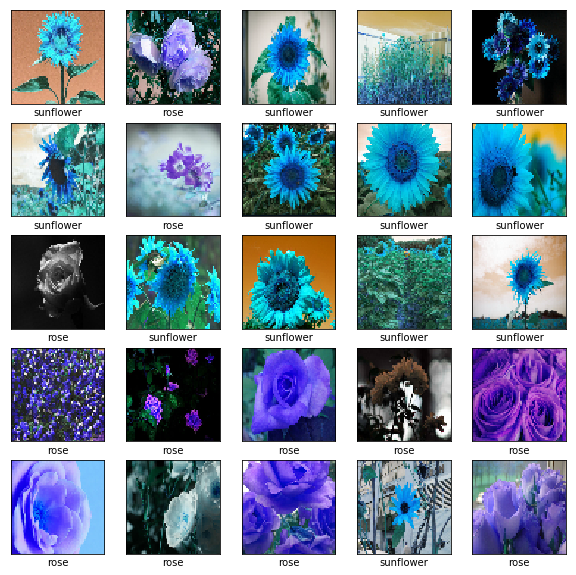

In [43]:
class_names = {0:'rose', 1:'sunflower'}
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

### Create deep learning model

In [8]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(64, 64, 3)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

### Compile and train model

In [9]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1092/1092 [==============================] - 1s 663us/step - loss: 1.5938 - acc: 0.6969
Epoch 2/5
1092/1092 [==============================] - 0s 334us/step - loss: 0.4003 - acc: 0.8700
Epoch 3/5
1092/1092 [==============================] - 0s 311us/step - loss: 0.3298 - acc: 0.8736
Epoch 4/5
1092/1092 [==============================] - 0s 312us/step - loss: 0.6201 - acc: 0.8205
Epoch 5/5
1092/1092 [==============================] - 0s 326us/step - loss: 0.4165 - acc: 0.8745


### Evaluate model using validation set

In [11]:
val_loss, val_acc = model.evaluate(X_val, y_val)

print(f'Validation accuracy: {val_acc*100}%')

274/274 [==============================] - 0s 457us/step
Validation accuracy: 88.68613143036835%


### Save model to JSON

In [12]:
# serialize model to JSON
model_json = model.to_json()
with open("simple_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("simple_model.h5")
print("Model successfully saved to disk!")

Model successfully saved to disk!


### Load model and evaluate on the test set

In [12]:
# load json and create model
json_file = open('simple_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("simple_model.h5")
print("Model successfully loaded from disk!")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

test_loss, test_acc = loaded_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc*100}%')

Model successfully loaded from disk!


NameError: name 'X_test' is not defined

### Show prediction result

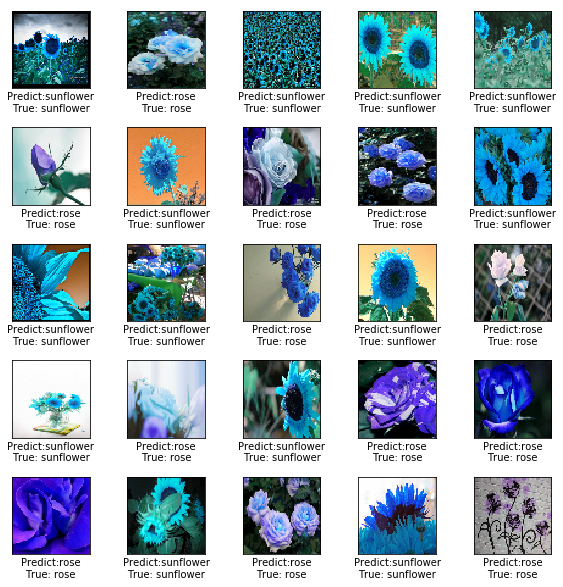

In [22]:
X_new = X_test
y_true = y_test
y_pred = model.predict_classes(X_new)
# show the inputs and predicted outputs
class_names = {0:'rose', 1:'sunflower'}
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplots_adjust(hspace = 0.5)
    plt.imshow(X_new[i], cmap=plt.cm.binary)
    plt.xlabel(f'Predict:{class_names[y_pred[i]]}\nTrue: {class_names[y_true[i]]}')

In [13]:
def save_the_image_path():
    current_path = os.getcwd()
    folder = 'test_images'
    path = pathlib.Path(os.path.join(current_path, folder))

    image_paths = [x for x in path.iterdir() if x.is_file()]
    return image_paths


def preprocess_test_data(image_paths):
    X = []
    size = 64, 64
    
    for img_path in image_paths:
        img = cv2.imread(str(img_path))
        im = cv2.resize(img,size)
        X.append(im)
    X = np.asarray(X)
    X = X/255.
    return X

def predict_using_simple_model(X):
    json_file = open('simple_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("simple_model.h5")
    print("Model successfully loaded from disk!")
    
    # compile and predict
    loaded_model.compile(optimizer=tf.train.AdamOptimizer(), 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    y_pred = loaded_model.predict_classes(X)
    return y_pred

def main():

    print('Put all your test images to the "/test_images" folder')
    image_paths = save_the_image_path()
    X = preprocess_test_data(image_paths)
    y_pred = predict_using_simple_model(X)
    class_names = {0:'rose', 1:'sunflower'}
    for i in range(len(X)):
        image_name = str(image_paths[i]).split('/')[-1]
        print(f'Image: {image_name}, Predict result: {class_names[y_pred[i]]}')


if __name__ == "__main__":
    main()

Put all your test images to the "/test_images" folder
Model successfully loaded from disk!
Image: 15951588433_c0713cbfc6_m.jpg, Predict result: rose
Image: 15965652160_de91389965_m.jpg, Predict result: rose
Image: 15972975956_9a770ca9dd_n.jpg, Predict result: sunflower
